# SMAPy - Soil Moisture Accounting Procedure in Python

SMAPy é um pacote em Python para calibração automática do modelo SMAP. O SMAP (Soil Moisture Accounting Procedure) é um modelo determinístico de simulação hidrológica do tipo transformação chuva-vazão. É o modelo oficial do Operador Nacional do Sistema para previsão de vazão das bacias mais importantes do Brasil afim de auxiliar o balanço de carga.

Com o SMAPy é possível calibrar o modelo e fazer o cálculo de vazões aplicando novos dados. Se o usuário já possui os parâmetros calibrados para alguma bacia, basta aplica-los as funções do pacote para realizar novos cálculos de vazão.

# SMAPy vs GRG-Solve

A implementação mais comum na comunidade para clibração do modelo SMAP é em uma planilha de excel, utilizando a ferramenta Solve para estimar a capacidade de saturação do solo (Sat), a constante de recessão do escoamento superficial (K2t) e o parâmtro de recarga subterrânea (Crec). O método da ferramenta Solve recomendado para estimar esses parâmtros é o Gradiente Reduzido Generalizado (GRG).

O pacote SMAPy traz uma inivação em relação a metodologia anteriormente citada. O pacote utiliza um método diferente de maximização de função. Além disso, o SMAPy aplica uma versão customizada do coeficiente de *Nash-Sutcliffe*. Abaixo será mostrado que o SMAPy produz resultados mais satistatórios que o método padrão. 

# Exemplo

Abaixo é ilustrado um exemplo para o rio Paranapanema. Os parâmetros *ebin*, *ai*, *capc*, *Ad* e *kkt* são normalmente definidos por um processo de tentativa e erro, pois são valores tabelados [(Limeira, 2015)](http://repositorio.unicamp.br/jspui/bitstream/REPOSIP/267742/1/Brianezi_ThaisRocha_M.pdf). Para este experimento, já há valores definidos para o rio Paranapanema e por isso serão mantidos. O foco deste experimento está em comparar os resultados obtidos pelos parâmetros *Sat*, *Crec* e *k2t* estimados pelo Solve do excel (Método padrão) e pelo SMAPy.

Novos Parâmetros estimados: Sat -> 445.81936825566197, Crec -> 3.5095434176017917, k2t -> 6.1519238084671555


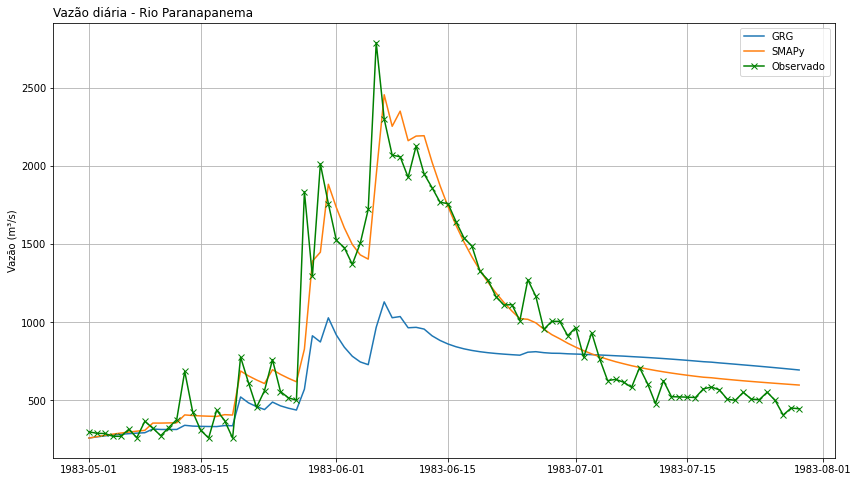

In [23]:
from SMAPy.SMAPy import SMAP
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

etp = pd.read_csv('data/etp.txt')
prec = pd.read_csv('data/prec.txt')
obs = pd.read_csv('data/vazao_obs.txt')

pesos = [0.3, 0.1, 0.12, 0.4,0.1] # Porcentagem de contribuição de cada estação

modelo_1 = SMAP(
    prec=prec, etp=etp, 
    Rsolo_init=400, ebin = 260, pesos=pesos,
    ai = 4, capc = 40, Ad=17800,
    kkt = 90, res_init = 0,
    sat = 800, crec = 15, k2t = 3
    )

modelo_1.predict() #Método para calcular a vazão a partir dos dados de entrada


modelo_2 = SMAP(
    prec=prec, etp=etp, 
    Rsolo_init=400, ebin = 260, pesos=pesos,
    ai = 4, capc = 40, Ad=17800,
    kkt = 90, res_init = 0
    )
modelo_2.fit(obs, guess=[500,5,5]) # Método para estimar os parâmtros. É possível dar valores aproximados para o método de maximização ter um ponto de partida.
modelo_2.predict()

print(f'Novos parâmetros estimados: Sat -> {modelo_2.sat}, Crec -> {modelo_2.crec}, k2t -> {modelo_2.k2t}')

datas = datelist = pd.date_range(datetime(1983,5,1), periods=modelo_1.vazao.shape[0]).tolist()

plt.figure(figsize=[14,8])
ax = plt.axes()
plt.plot(datas, modelo_1.vazao, label='GRG')
plt.plot(datas, modelo_2.vazao, label='SMAPy')
plt.plot(datas, obs['obs'], 'g-x', label='Observado')
plt.title('Vazão diária - Rio Paranapanema', loc='left')
plt.ylabel('Vazão (m³/s)')
ax.legend()
plt.grid(True)
plt.show()


É possível notar que o modelo calibrado com o SMAPy produziu resultados mais satisfatórios em comparação com o modelo calibrado com o Solve. No início da série, com valores de vazão mais contidos, ambos os métodos estimaram razoavelmente bem a vazão. Porém, com o aumento subto da vazão, somente o modelo calibrado pelo SMAPy foi capaz de acompanhar de forma razoável a vazão observada, enquanto o modelo calibrado pelo Solve subestimou a vazão. 

No declínio da curva de vazão é possível ver superioridade do modelo calibrado pelo SMAPy, que acompanhou de forma razoável a curva da vazão observada. Por outro lado, o modelo calibrado com o Solve estabilizou a vazão por um longo período até que em certo ponto deixou de subestimar a vazão para superestimar o observado.